# <center> **Project 4: Classification. BASELINE**

Banks would like to be able to choose among their customers exactly those who are most likely to take advantage of a particular offer, and contact them.

You were provided with data on the latest marketing campaign conducted by the bank: the task was to attract customers to open a deposit. You must analyze this data, identify patterns and find the decisive factors that influenced the fact that the client invested money in this particular bank. If you can do this, you will raise the bank's income and help understand the target audience that needs to be attracted through advertising and various offers.

**Business task:** to determine the characteristics by which it is possible to identify customers who are more inclined to open a deposit in a bank, and thereby increase the effectiveness of a marketing campaign.

**Technical task:** to build a machine learning model that, based on the proposed characteristics of the client, will predict whether he will take advantage of the offer to open a deposit or not.

**Target value:** F1-score

**Bank customer data:**
- age (age);
- job (field of employment);
- marital (marital status);
- education (level of education);
- default (whether there is an overdue loan);
- housing (whether there is a loan for housing);
- loan (whether there is a loan for personal needs);
- balance (balance).

**Data related to the last contact in the context of the current marketing campaign:**
- contact (type of contact with the client);
- month (the month in which the last contact was made);
- day (the day the last contact was made);
- duration (contact duration in seconds).

**Other signs:**
- campaign (number of contacts with this client during the current campaign);
- pdays (the number of days missed from the last marketing campaign to the contact in the current campaign);
- previous (number of contacts before the current campaign)
- poutcome (the result of a past marketing campaign).

**Target variable is deposit**, which determines whether the client agrees to open a deposit with the bank. This is what we will try to predict in this case.

In [15]:
# main
import pandas as pd
import numpy as np
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn import ensemble, metrics, tree, linear_model

# machine learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import optuna
from optuna.integration import OptunaSearchCV

# ensembles
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.ensemble import IsolationForest

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import joblib

# coders
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

## <center> <span style='color:red'> **Part I. Data Explore and Cleaning**

In [16]:
# load and explore our data
data = pd.read_csv('bank_fin.csv', sep = ';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [17]:
# continue exploring our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### <span style='color:green'> **Task 1** 
Find missing values.

In [18]:
# check for gaps in our data
data.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### <span style='color:green'> **Task 2**
Find implicit missing values.

In [19]:
# are there any missing values in the 'job'?
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### <span style='color:green'> **Task 3**
The balance characteristic data contains an extra comma and a dollar sign. Handle this feature.

In [20]:
def balance_changing (row):
    """func for work with 'balance' column"""
    
    row = str(row)
    
    if row != 'unknown':
        row = row.replace('$', '')
        row = row.replace(' ', '')
        row = row.replace(',00', '')
        return row
    
    else:
        return np.nan

# handle this feature 
data['balance'] = data['balance'].apply(balance_changing)

# this column has object type, let's fix this
data['balance'] = data['balance'].astype(float)

# have to find a mean value
print(round(data['balance'].mean(), 3))

1529.129


### <span style='color:green'> **Task 4**
Fill in the gaps  in this feature with the median value.

In [21]:
# fix missing values in balance by a mean value
data['balance'] = data['balance'].fillna(data['balance'].median())

# have to find the new mean
print(round(data['balance'].mean(), 3))

1526.936


### <span style='color:green'> **Task 5**
Replace all missing values in the job attribute with modal ones. Do the same with the sign responsible for the level of education.

In [22]:
# fill in the gaps with modal values
data['education'] = data['education'].replace('unknown', 'secondary')
data['job'] = data['job'].replace('unknown', 'management')

# the task is finding the mean balance for the most popular job and education
df_new = data[(data['job'] == 'management') & (data['education'] == 'secondary')]
print(round(df_new['balance'].mean(), 3))

1598.883


### <span style='color:green'> **Task 6**
Examine the customer balance feature for outliers. Find these boundaries using the Tukey method, and filter the values so that there are no outliers in the data.

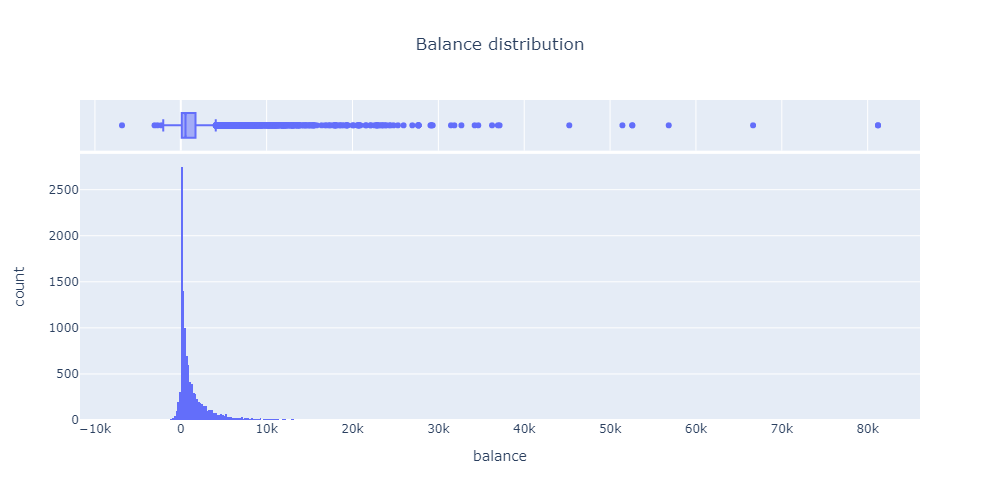

In [23]:
# discard outliers for the balance feature
# firstly let's check a distribution of this feature
hist_balance = px.histogram(
    data_frame=data,
    x='balance',
    marginal='box',
    width=1000,
    title='Balance distribution'
)

hist_balance.update_layout(title=dict(x=.5, xanchor='center'))

hist_balance.show('png')

In [24]:
# need to use tykey method
# looks like a non-normal distribution, but we don't need to log on the task condition
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """Func for the interquartile range method"""
    
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned, lower_bound, upper_bound

# use this func for the balance
outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod(data, 'balance')

# find the lower and the upper range
print('The lower bound: ', round(lower_bound))
print('The upper bound: ', round(upper_bound))

# update our dataset by the cleaned data
data = cleaned


The lower bound:  -2241
The upper bound:  4063


### <span style='color:green'> **Task 7**
Check a dataset size

In [25]:
# check the size of the dataset
data.shape

(10105, 17)

## <center> <span style='color:red'> **Part II. Exploratory Data Analysis**

In [26]:
# we will use this color palette for a more beautiful visualization
color_map = {"no": "red", "yes": "green"} 

### <span style='color:green'> **Task 1**
Examine the distribution of the target variable: is there class imbalance?

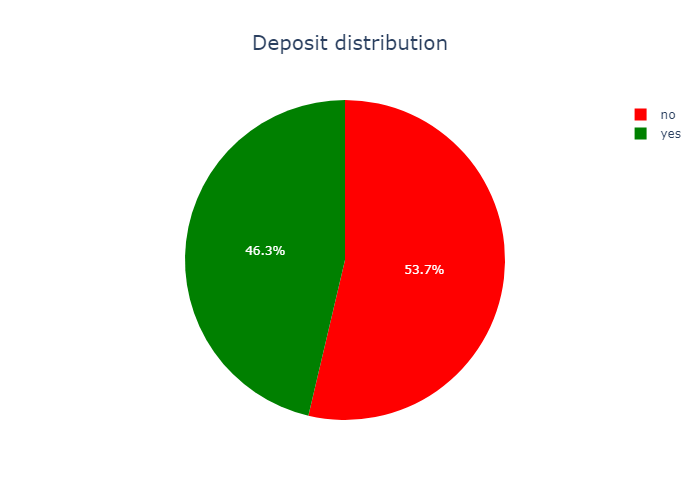

In [27]:
# check distribution of tha target value
deposit_distribution = px.pie(
    data_frame=data,
    names='deposit',
    title='Deposit distribution',
    color='deposit',
    color_discrete_map=color_map
)
deposit_distribution.update_layout(
    title=dict(x=.5, xanchor="center"),
    title_font_size=20
)

# display this plot
deposit_distribution.show('png')

**Conclusion:**  
The distribution by the presence a deposit is almost equal, but a smaller number of people have a deposit in this data.
__________

### <span style='color:green'> **Task 2 and 3**  
Explore and explane numerical features.

In [28]:
# descriptive statistics for numerical features
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


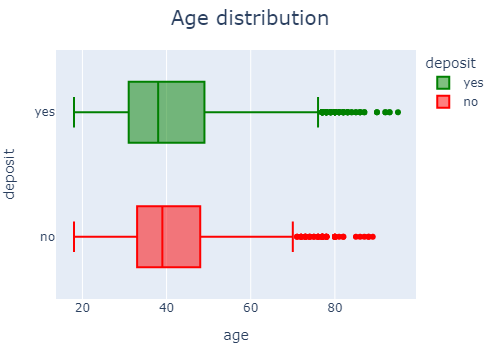

In [29]:
# explore age feature
age_boxplot = px.box(
    data_frame=data,
    x='age',
    y='deposit',
    color='deposit',
    title='Age distribution',
    height=350,
    width=500,
    color_discrete_map=color_map
)
age_boxplot.update_layout(title=dict(x=.5, xanchor='center'),
                          margin=dict(l=10, r=10, t=50, b=50),
                          title_font_size=20)

# display the plot
age_boxplot.show('png');

**Conclusion:**  
Seems an age over 71 and 77 years could be a abnormal value. Perhaps it should be taken into account at the stage of a machine learning. Generally people with deposit have more wider range of ages, but the median value is slightly larger more in 'no' category.
______________________________

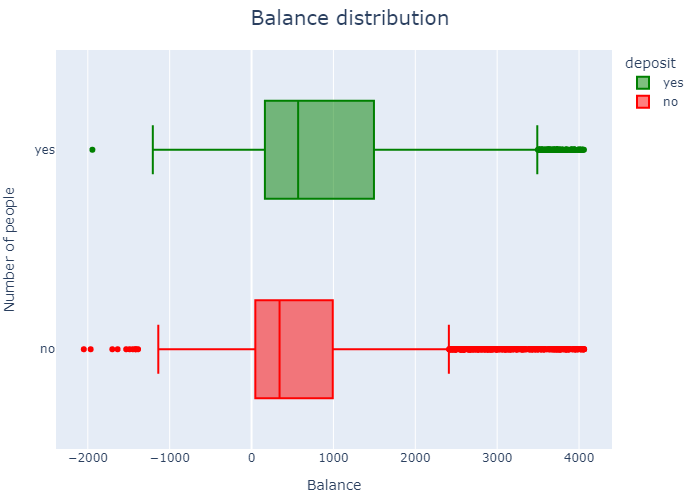

In [30]:
# explore balance feature
balance_boxplot = px.box(
    data_frame=data,
    x='balance',
    y='deposit',
    color='deposit',
    title='Balance distribution',
    color_discrete_map=color_map
)
balance_boxplot.update_layout(
    yaxis_title='Number of people',
    xaxis_title='Balance',
    title_font_size=20,
    title=dict(x=.5, xanchor='center'),
    margin=dict(l=10, r=10, t=50, b=50))

# display the plot
balance_boxplot.show('png');

**Conclusion:**  
People with a deposit have more money on their account. But almost equal number of people have a negative balance.
_______________________________________________________

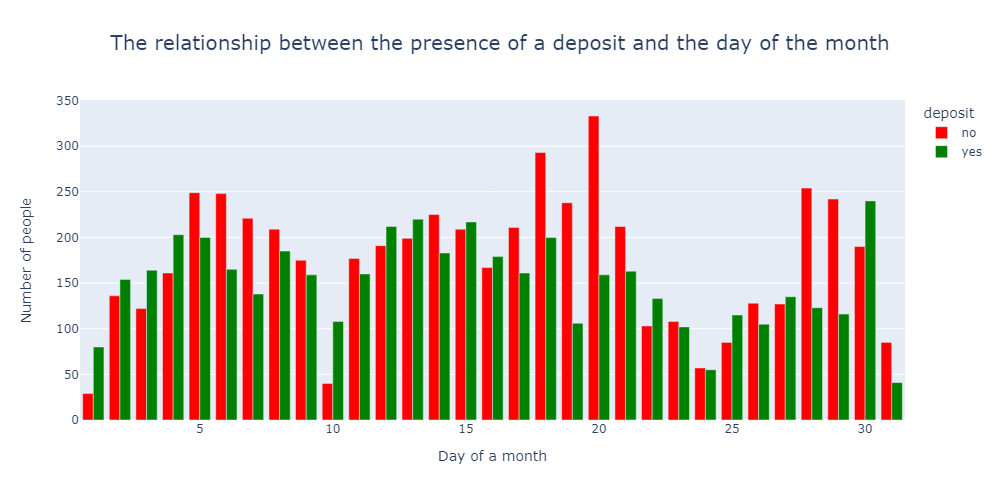

In [31]:
# group the data
last_contact = data.groupby(['day', 'deposit'], as_index=False).count()

# study the significance of the day of the month
last_contact_day = px.bar(
    data_frame=last_contact,
    x='day',
    y='contact',
    color='deposit',
    barmode = 'group',
    title='The relationship between the presence of a deposit and the day of the month',
    width=1000,
    color_discrete_map=color_map
)

last_contact_day.update_layout(
    xaxis_title='Day of a month',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center',
    font_size=20)
)

# dispaly the plot
last_contact_day.show('png')

**Conclusion:**  
Not so obvious, but in the first and last days and also in the middle of a month, the number of people who were taken a deposit, is bigger.

### <span style='color:green'> **Task 4 and 5**  
Explore and explane categorical features.

In [32]:
# descriptive statistics for categorical features
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


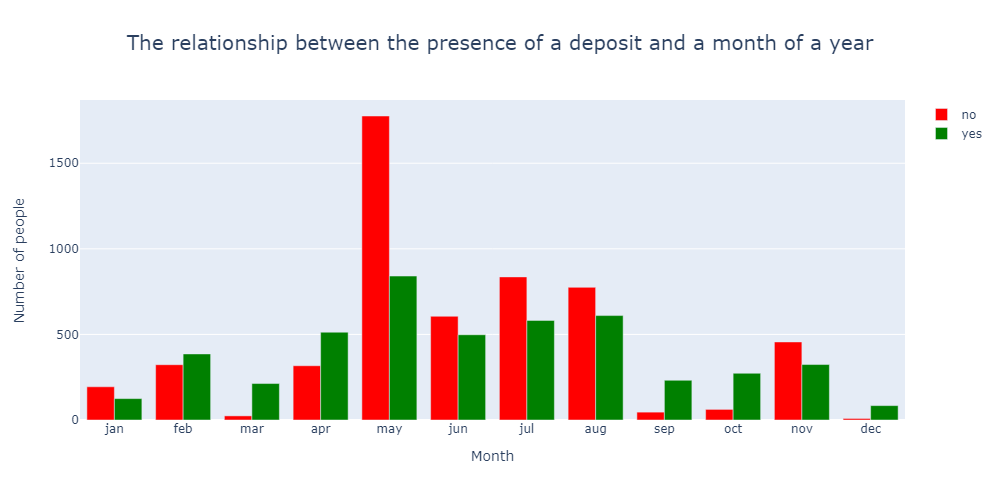

In [33]:
# create a month list for prettier visualisation
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# group the data
grouped_by_month = data.groupby('month')['deposit'].value_counts(normalize=False).unstack().reset_index()

# study the influence of the month of the year on the availability of a deposit
fig = go.Figure(data=[
    go.Bar(name='no ', x=grouped_by_month['month'], y=grouped_by_month['no'], marker_color='red'),
    go.Bar(name='yes', x=grouped_by_month['month'], y=grouped_by_month['yes'], marker_color='green')
])

fig.update_layout(
    barmode='group',
    xaxis={'categoryarray': months},
    xaxis_title='Month',
    yaxis_title='Number of people',
    title='The relationship between the presence of a deposit and a month of a year',
    width=1000
)

fig.update_layout(
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display this plot
fig.show('png')

**Conclusion:**  
Seems the most successful months were May and summer, because the largest number of deposits were taken during that time. Also seems the beginning and the end of a year are not useful periods for any campaign.  
But we can see a huge number of failure at May. Thus we should estimate success of a month in terms of the ration refusals to all proposals.
_________

### <span style='color:green'> **Task 6** 
Find out if there is a difference in the results of the current marketing campaign and the previous one.

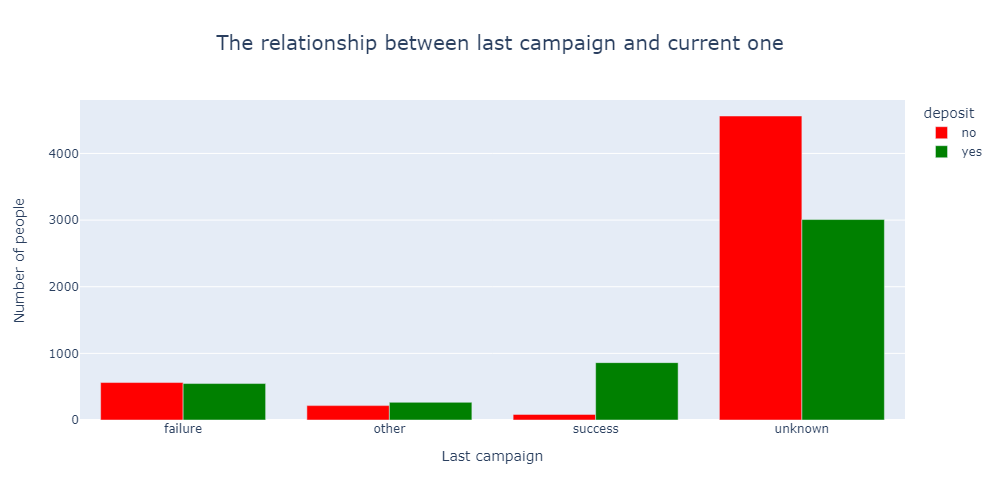

In [34]:
# let's compare last campaign and the current one
last_campaign = data.groupby('poutcome', as_index=False)['deposit'].value_counts()
# let's take a closer look
last_camp_plot = px.bar(
    data_frame=last_campaign,
    x='poutcome',
    y='count',
    color='deposit',
    barmode = 'group',
    title='The relationship between last campaign and current one',
    width=1000,
    color_discrete_map=color_map
)

last_camp_plot.update_layout(
    xaxis_title='Last campaign',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display this plot
last_camp_plot.show('png')

**Conclusion:**  
For God's sake... Seems this compaign is more successful.
__________

### <span style='color:green'> **Task 7** 
Calculate which month has the highest percentage of interaction failures in the current marketing campaign.

In [35]:
# firstly we should get this rate
def get_failure_rate(month):
    """Func to calculate bounce rate"""
    
    ratio = len(data[(data['deposit'] == 'no') & (data['month'] == month)])  / len(data[data['month'] == month])
    
    return ratio

# create new feature for work
data['fail_rate_month'] = data['month'].apply(get_failure_rate)

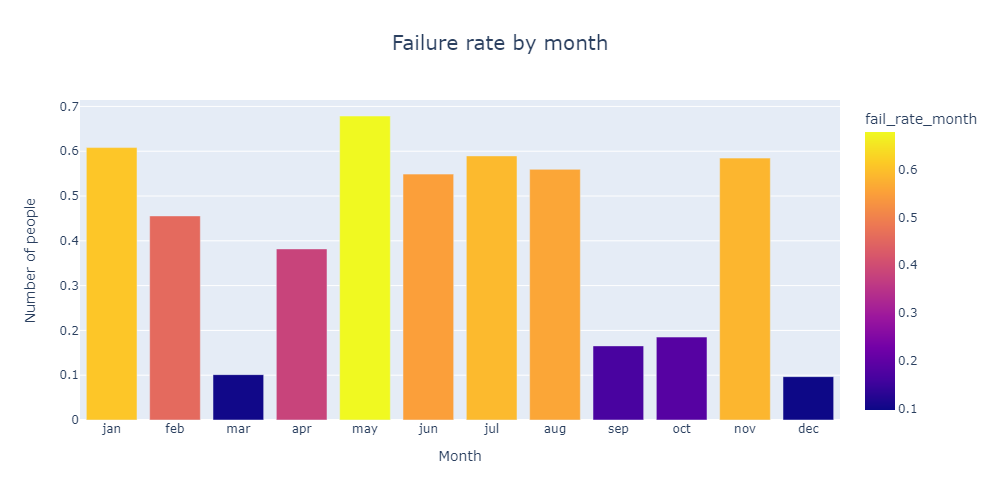

In [36]:
# let's see the result
fail_month_df = data.groupby('month', as_index=False)['fail_rate_month'].value_counts(normalize=False)

# month must be in order
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# picturaze
fail_rate_plot = px.bar(
    data_frame = fail_month_df,
    x='month',
    y='fail_rate_month',
    title='Failure rate by month',
    color='fail_rate_month',
    width=1000
)

fail_rate_plot.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20,
    xaxis={'categoryarray': months}
)
fail_rate_plot.show('png')

**Conclusion:**  
There is a suddenly absolutely reverse result in this plot. Lately we haven't noticed december and march, but these months can show impressive results.  
So I mean there was the biggest number of deposits in May, but only because of a more active offer.
__________

### <span style='color:green'> **Task 8** 
Create a new variable that will contain an indicator of membership. Create age groups and determine which groups are more likely to open a deposit than to refuse an offer.

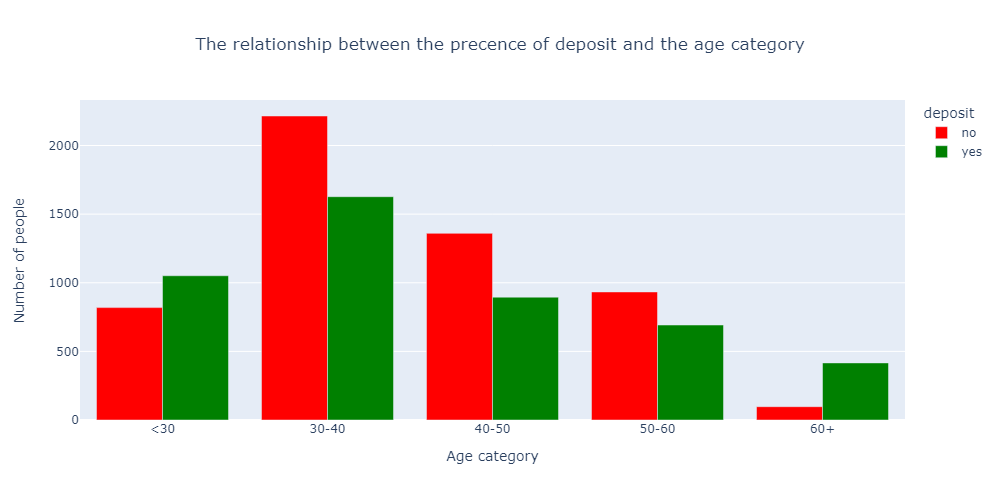

In [37]:
# create categorical age
data['age_category'] = pd.cut(data.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

# group data
deposit_age_df = data.groupby('age_category', as_index=False)['deposit'].value_counts().sort_values(by=['age_category', 'count'])

# picturaze
deposit_age_plot = px.bar(
    data_frame = deposit_age_df,
    x='age_category',
    y='count',
    title='The relationship between the precence of deposit and the age category',
    color='deposit',
    barmode='group',
    width=1000,
    color_discrete_map=color_map
)

# add names
deposit_age_plot.update_layout(
    xaxis_title='Age category',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center')
)

# display
deposit_age_plot.show('png')

**Conclusion:**  
Only the 'young' and the 'retired' are more likely to agree opening a deposit.
______________

### <span style='color:green'> **Task 9 and 10** 
Build visualizations for those who have opened and not opened a deposit depending on marital status.

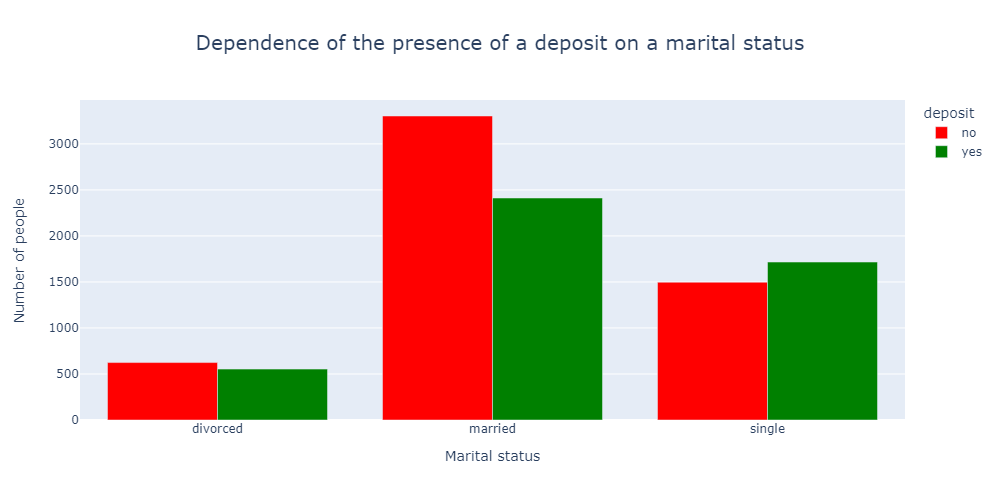

In [38]:
# group our data
marital_grouped = data.groupby('marital', as_index=False)['deposit'].value_counts()

# picturaze
deposit_on_marital_plot = px.bar(
    data_frame=marital_grouped,
    x='marital',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on a marital status',
    width=1000,
    color_discrete_map=color_map
)

deposit_on_marital_plot.update_layout(
    xaxis_title='Marital status',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

deposit_on_marital_plot.show('png')

**Conclusion:**  
The divorced and married people are more likely to refuse deposit offers.
______________

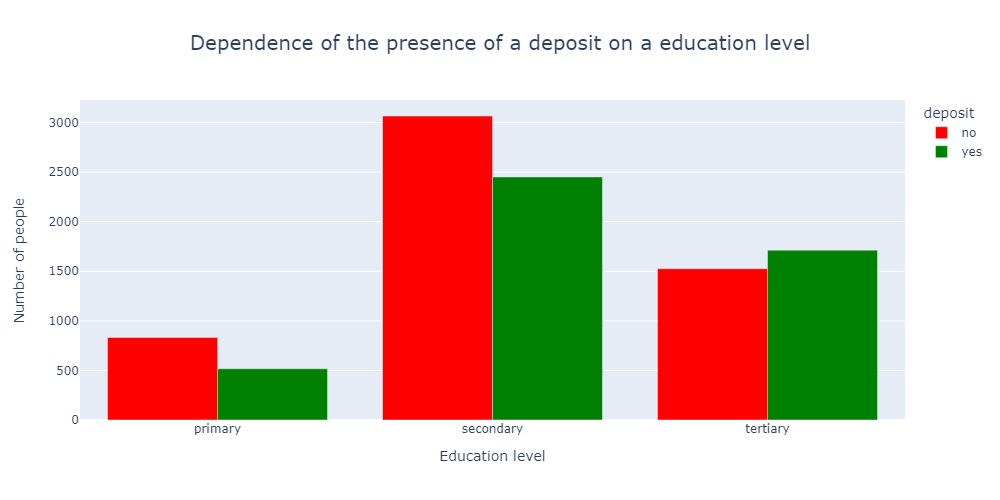

In [39]:
# build visualizations for those who have opened and not opened a deposit, depending on the education
# group our data
education_grouped = data.groupby('education', as_index=False)['deposit'].value_counts()

# picturaze
deposit_education_plot = px.bar(
    data_frame=education_grouped,
    x='education',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on a education level',
    width=1000,
    color_discrete_map=color_map
)

deposit_education_plot.update_layout(
    xaxis_title='Education level',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

deposit_education_plot.show('png')

**Conclusion:**  
People with a higher level of education are more likely to take a deposit.
______________

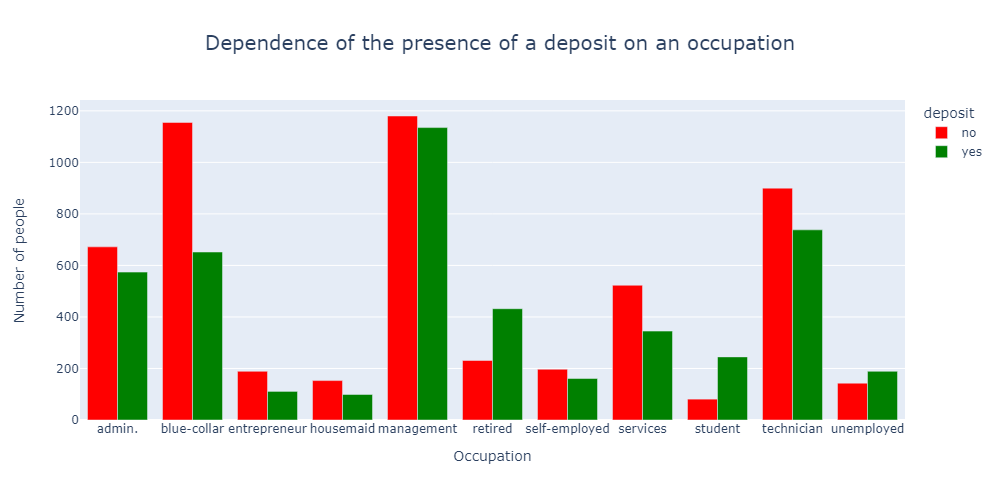

In [40]:
# build visualizations for those who have opened and not opened a deposit,
# depending on the type of professional employment

# group our data
job_grouped = data.groupby('job', as_index=False)['deposit'].value_counts()

# picturaze
deposit_job_plot = px.bar(
    data_frame=job_grouped,
    x='job',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on an occupation',
    width=1000,
    color_discrete_map=color_map
)
# add names
deposit_job_plot.update_layout(
    xaxis_title='Occupation',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# display
deposit_job_plot.show('png')

**Conclusion:**  
So most often the retired, students and the unemployed have a deposit. That is quite obvious, since these categories prefer more conservative investments.
__________

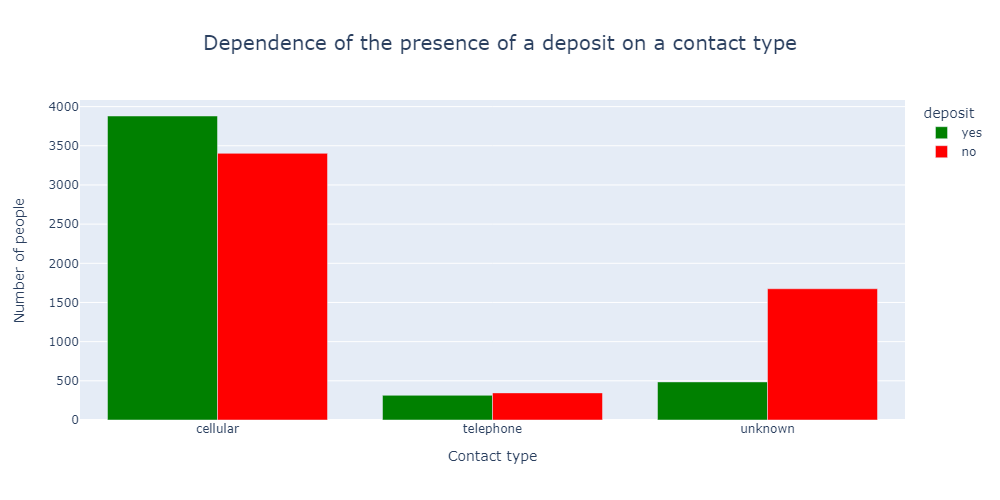

In [41]:
# build visualizations for those who have opened and not opened a deposit, depending on the education
# group our data
contact_grouped = data.groupby('contact', as_index=False)['deposit'].value_counts()

# picturaze
deposit_contact_plot = px.bar(
    data_frame=contact_grouped,
    x='contact',
    y='count',
    color='deposit',
    barmode='group',
    title='Dependence of the presence of a deposit on a contact type',
    width=1000,
    color_discrete_map=color_map
)

deposit_contact_plot.update_layout(
    xaxis_title='Contact type',
    yaxis_title='Number of people',
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

deposit_contact_plot.show('png')

**Conclusion:**  
We can see that in a group where the contact type is unknown, the probability of failure is almost 4 times higher.
_______

### <span style='color:green'> **Task 11**
Build a pivot table to identify people with what education and marital status are the most numerous.

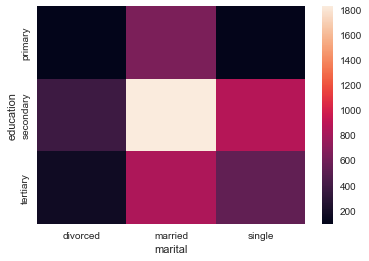

In [42]:
# firstly let's picturaze group without deposit 
no_deposit = data[data['deposit'] == 'no']
no_crossed_df = pd.crosstab(no_deposit.education, no_deposit.marital)
sns.heatmap(no_crossed_df);

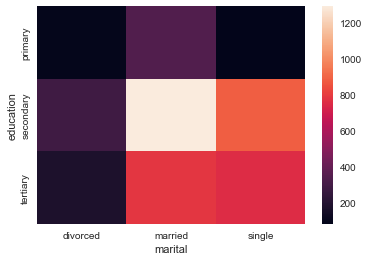

In [43]:
# now people with deposit
yes_deposit = data[data['deposit'] == 'yes']
yes_crossed_df = pd.crosstab(yes_deposit.education, yes_deposit.marital)
sns.heatmap(yes_crossed_df);

**Conclusion:**  
The presented groups are almost identical, but the main difference witch we've already noticed is that single people and people with higher education are more likely to take a deposit.
_______ 

## <center> <span style='color:red'> **Part III. Selection and transformation of features**

### <span style='color:green'> **Task 1**
Let's start with processing a categorical ordinal feature that is responsible for the level of education: education.  
Handle it with the LabelEncoder.

In [44]:
# encoding 'education'
education_encoder = LabelEncoder()
data['education'] = education_encoder.fit_transform(data['education'])

### <span style='color:green'> **Task 2 and 3**
Treat the age feature and the target variable in the same way so that it can be used when training the model.

In [45]:
# encoding age
age_encoder = LabelEncoder()
data['age_category'] = age_encoder.fit_transform(data['age_category'])

In [46]:
# encoding target variable
data['deposit'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

# need to calculate std
round(data['deposit'].std(), 3)

0.499

Let's do it the same for other binary features, of which we have three - default, loan, housing.

In [47]:
# encoding binary features
binary_encoder = lambda x: 1 if x=='yes' else 0

# use this func
data['default'] = data['default'].apply(binary_encoder)
data['housing'] = data['housing'].apply(binary_encoder)
data['loan'] = data['loan'].apply(binary_encoder)

# calculate the sum of the means value of these above features
three_means_sum = data['default'].mean() + data['housing'].mean() + data['loan'].mean()
round(three_means_sum, 3)

0.635

### <span style='color:green'> **Task 4**
Now we need to convert the nominal variables, which can take on several different values. Use dummies, but save the original features.

In [48]:
# make dummies
dummy_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df = data[dummy_features]

# encoding 
data = pd.get_dummies(data, columns=dummy_features) # cleaned and encodered data

# we need leave these features according to the task condition
cat_data = pd.concat([data, df], axis=1) # new data with categorial features
cat_data.shape

(10105, 52)

In [49]:
# unfortunately we should drop failure rate by month - this is the conditions of the assignment
cat_data = cat_data.drop(['fail_rate_month'], axis=1)
cat_data.shape

(10105, 51)

### <span style='color:green'> **Task 5 and 6**
Build a correlation matrix. Complete it with a heat map reflecting the result.
As a visualization addition to this task, construct a bar chart for the ranked correlation coefficients.

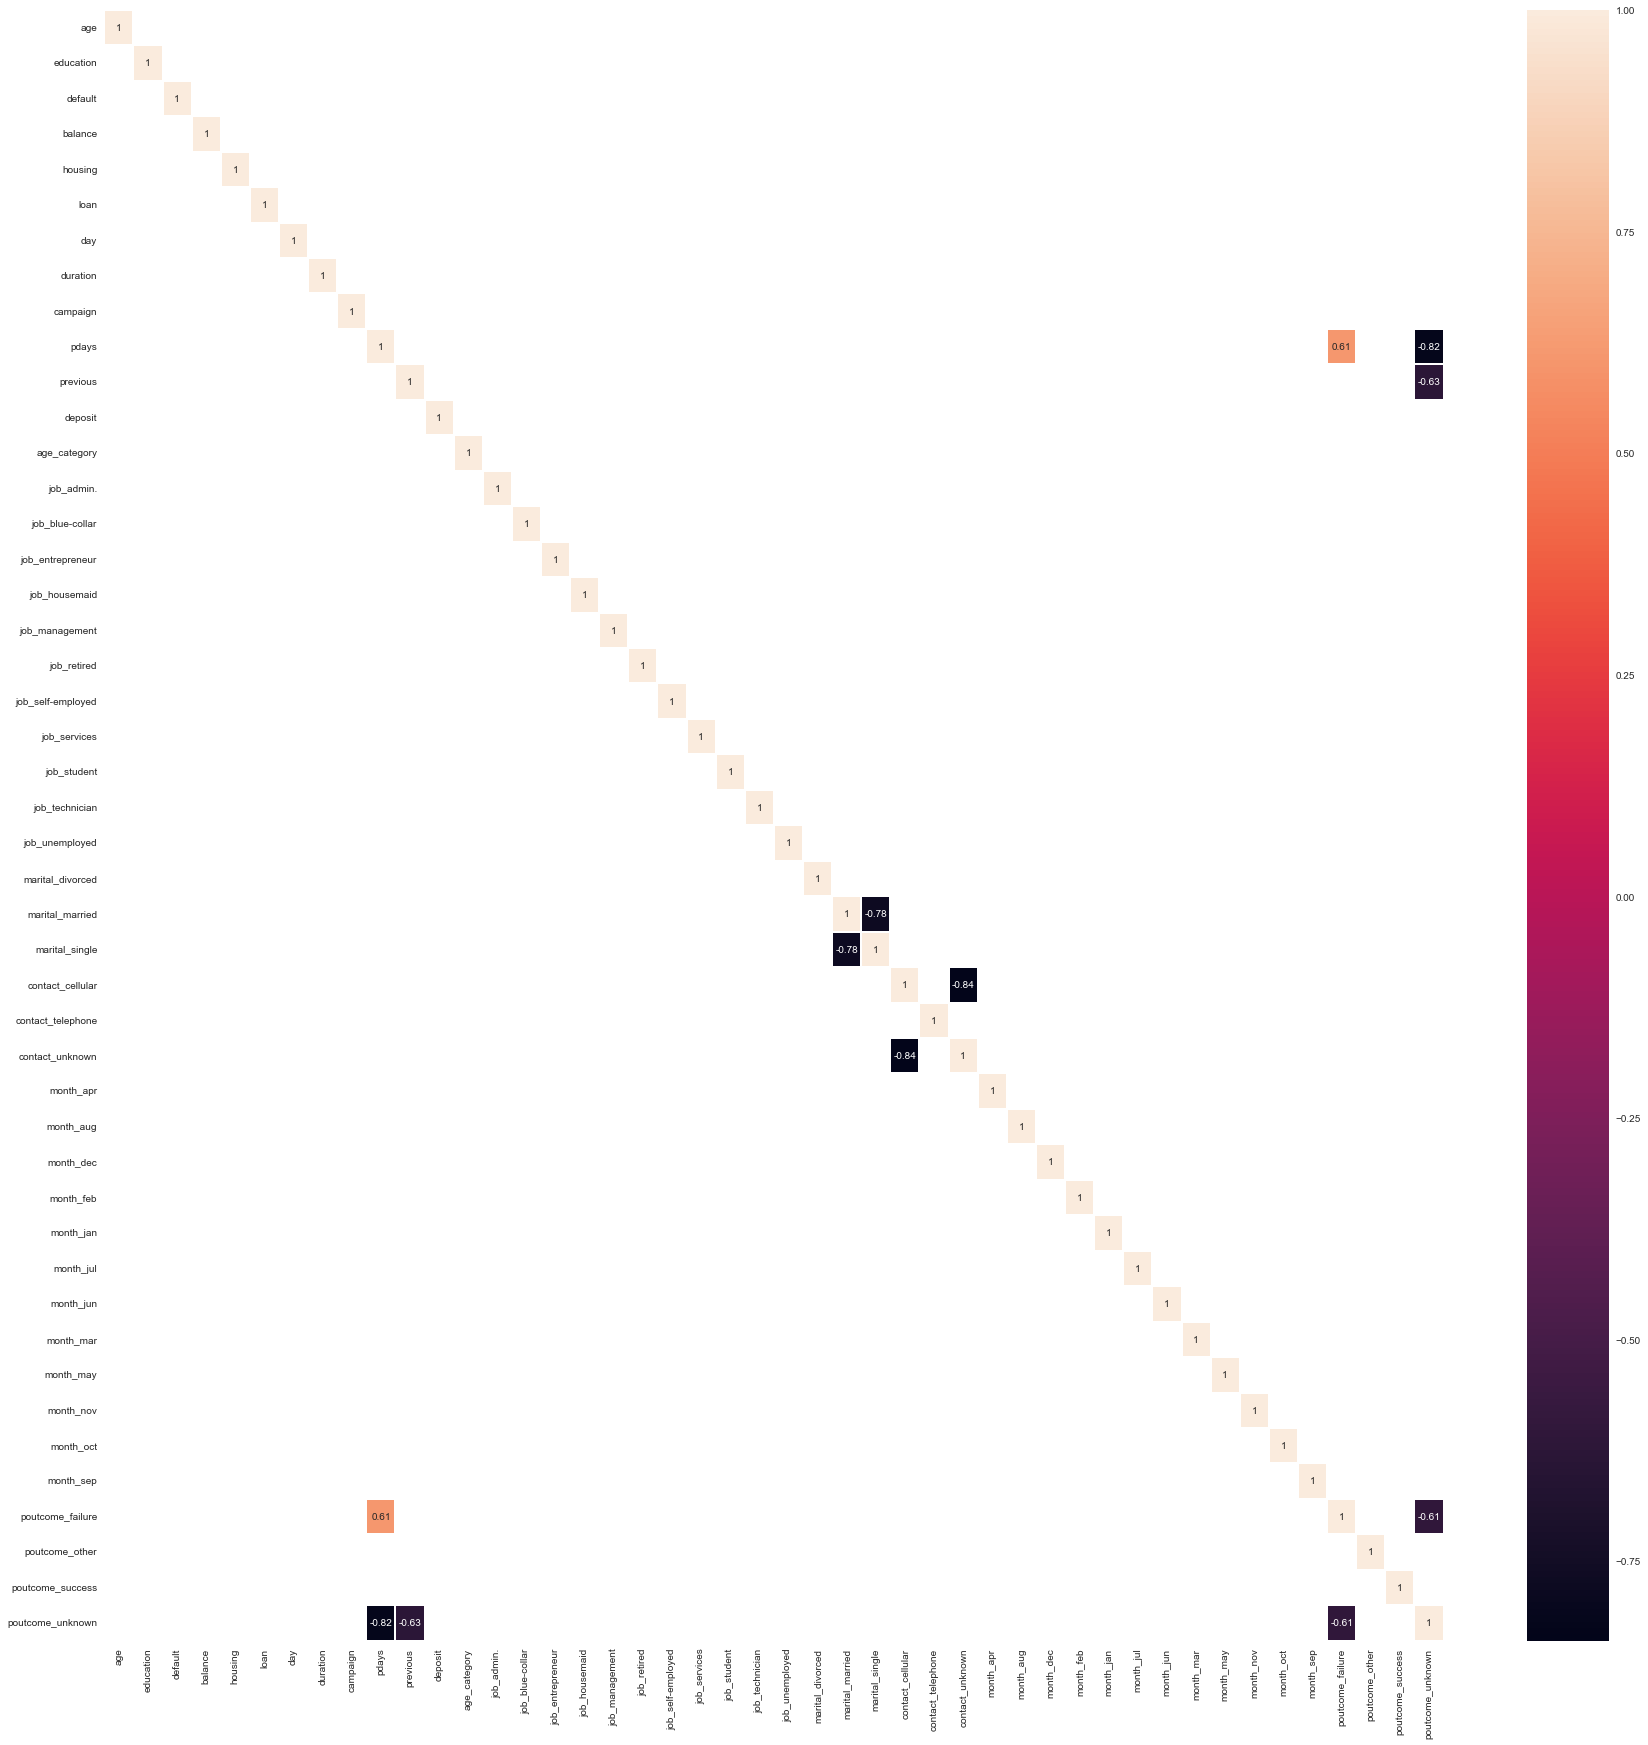

In [50]:
# build heatmap for searching multicollinear features
corr = cat_data.corr()
fig = plt.figure(figsize=(30,30))
sns.heatmap(round(corr[corr.abs() > 0.6], 2), annot=True, linewidths=0.1);

**Conclusion:**  
We will consider multicollinear features only those for which correletaion is more than |0.9|.
____

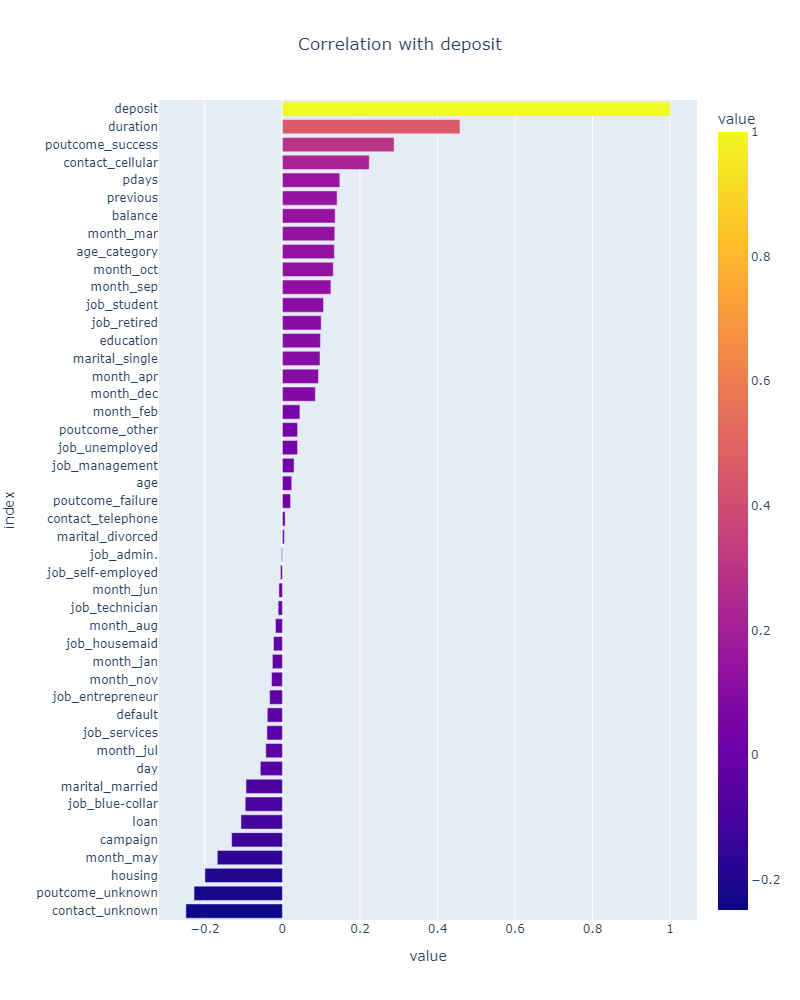

In [51]:
# now let's see a correlation with the target feature
# group data
corr_df = round(corr['deposit'].sort_values(ascending=True), 3)

# picturaze
deposit_corr = px.bar(
    data_frame=corr_df,
    orientation='h',
    color='value',
    height=1000,
    width=800,
    title='Correlation with deposit'
)
deposit_corr.update_layout(title=dict(x=.5, xanchor='center'))

# display
deposit_corr.show('png')

### <span style='color:green'> **Task 7 and 8**
Now let's split our data into train and test parts. 

In [52]:
# will use cleaned data
# should drop this useful feature
data = data.drop('fail_rate_month', axis=1)

# create X and y
X = data.drop(['deposit'], axis=1)
y = data['deposit']

# spliting 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Training sample size is:', X_train.shape)
print('Testing sample size is:', X_test.shape)

# find target mean value - the condition task
print('A mean value of target value in testing sample is', round(y_test.mean(), 2))

Training sample size is: (6770, 45)
Testing sample size is: (3335, 45)
A mean value of target value in testing sample is 0.46


### <span style='color:green'> **Task 9**
At the moment, we have quite a lot of signs: most likely, not all of them will be important. Let's leave only those that are most related to the target variable and will definitely contribute to improving the quality of the model.

Use SelectKBest to select the 15 features best suited for use in the problem. Only numerical.

In [53]:
# reduce our sample to 15 features
selector = SelectKBest(f_classif, k=15)
selector = selector.fit(X_train, y_train)

# display the best 15 features
print(selector.get_feature_names_out())

# transform samples
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# check dimensions
print(X_train.shape, X_test.shape)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_category' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']
(6770, 15) (3335, 15)


### <span style='color:green'> **Task 10**
Now the data needs to be normalized.

There are different options for normalization, but we will use min-max normalization.

In [54]:
# call a scaler
scaler = MinMaxScaler()

# apply to sample
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# check the first feature mean value
round(X_test_scaled[:, 0].mean(), 2)

0.47

## <center> <span style='color:red'> **Part IV. Machine Learning**

### <center> <span style='color:red'> ***1. Logistic Regression and Decision Tree***

### <span style='color:green'> **Task 1**
Train a logistic regression model. We will use 'sag' as the optimization algorithm, take the number 42 as the value of the random_state parameter and run 1000 iterations.

In [55]:
# build the model with the given params
log_reg = linear_model.LogisticRegression(
    random_state=42,
    solver='sag',
    max_iter=1000
)

# training the model
log_reg.fit(X_train_scaled, y_train)

# predict and calculate metrics for the training
y_train_pred = log_reg.predict(X_train_scaled)
print('Train F1-score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_'*25)

# predict and calculate metrics for the testing
y_test_pred = log_reg.predict(X_test_scaled)
print('Test F1-score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1-score: 0.800
Train accuracy: 0.824
_________________________
Test F1-score: 0.781
Test accuracy: 0.808


### <span style='color:green'> **Task 2-4**
Now we will train another simple model - the decision tree. Let's start with the following as parameters (criterion = 'entropy'; random_state = 42). Leave the rest of the settings as default.

In [56]:
# train a simple decision tree with the given params
decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# training the model
decision_tree.fit(X_train_scaled, y_train)

# predict and calculate metrics for the training
y_train_pred = decision_tree.predict(X_train_scaled)
print('Train F1-score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate metrics for the testing
y_test_pred = decision_tree.predict(X_test_scaled)
print('Test F1-score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1-score: 1.000
Train accuracy: 1.000
_________________________
Test F1-score: 0.727
Test accuracy: 0.749


Looks like are dealing with model retraining.
__________
Iterate through the various maximum tree depths and find the tree depth for which there will be a maximum value of the accuracy metric, but without overfitting yet. Don't use any optimization methods 

In [57]:
# add max depth and number of leaves
decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6,
    min_samples_leaf=5
)

# training the model
decision_tree.fit(X_train_scaled, y_train)

# predict and calculate metrics for training
y_train_pred = decision_tree.predict(X_train_scaled)
print('Train F1-score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate metrics for testing
y_test_pred = decision_tree.predict(X_test_scaled)
print('Test F1-score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1-score: 0.812
Train accuracy: 0.817
_________________________
Test F1-score: 0.801
Test accuracy: 0.806


### <span style='color:green'> **Task 5**
Implement hyperparameter optimization with GridSearch by looping through the following parameters:  
'min_samples_split': [2, 5, 7, 10];  
'max_depth':[3,5,7].

In [58]:
# will use only these params for gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]}

# build hyperparameter optimization 
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    n_jobs=-1
)

# training the model
grid_search.fit(X_train_scaled, y_train)

# predict and calculate metrics for the training
y_train_pred = grid_search.predict(X_train_scaled)
print('Train F1 score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate metrics for the testing
y_test_pred = grid_search.predict(X_test_scaled)
print('Test F1 score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1 score: 0.823
Train accuracy: 0.833
_________________________
Test F1 score: 0.803
Test accuracy: 0.813


### <center> <span style='color:red'> ***2. Ensembles***

### <span style='color:green'> **Task 1**
Train a random forest with the following parameters:  
- n_estimators = 100;
- criteria = 'gini';
- min_samples_leaf = 5;
- max_depth = 10;
- random_state = 42.

In [59]:
# build this model
random_forest = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

# train our random forest
random_forest.fit(X_train_scaled, y_train)

# predict and calculate metrics for the training sample
y_train_pred = random_forest.predict(X_train_scaled)
print('Train F1 score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate for the testing sample
y_test_pred = random_forest.predict(X_test_scaled)
print('Test F1 score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train F1 score: 0.848
Train accuracy: 0.857
_________________________
Test F1 score: 0.817
Test accuracy: 0.827


### <span style='color:green'> **Task 2-3**
Try to improve your results with a gradient boosting model with the following parameters:
- learning_rate = 0.05;
- n_estimators = 300;
- min_samples_leaf = 5;
- max_depth = 5;
- random_state = 42.

In [60]:
# build the model
gradient_boost = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

# training the model
gradient_boost.fit(X_train_scaled, y_train)

# predict and calculate results for the training
y_train_pred = gradient_boost.predict(X_train_scaled)
print('Train f1 score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)

# predict and calculate results for the testing
y_test_pred = gradient_boost.predict(X_test_scaled)
print('Test f1 score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train f1 score: 0.879
Train accuracy: 0.887
_________________________
Test f1 score: 0.816
Test accuracy: 0.826


### <span style='color:green'> **Task 4**
In this task, you need to use stacking by combining the algorithms that you have already used before: decision trees, logistic regression and gradient boosting (the parameters are the same). Use a logistic regression model as the metamodel.

In [61]:
# build a stack model
estimators = [
    ('dt', decision_tree),
    ('lr', log_reg),
    ('gb', gradient_boost)
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

# training the model
stacking.fit(X_train_scaled, y_train)

# predict and calculate results for the training
y_train_pred = stacking.predict(X_train_scaled)
print('Train f1 score: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('_' * 25)


# predict and calculate results for the testing
y_test_pred = stacking.predict(X_test_scaled)
print('Test f1 score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train f1 score: 0.858
Train accuracy: 0.868
_________________________
Test f1 score: 0.810
Test accuracy: 0.824


### <span style='color:green'> **Task 5**
Of course, not all signs are equally good at predicting the outcome of a marketing campaign. In order to select the aspects that are most significant for us, which we will need to pay attention to when implementing the next action, let's choose three features that make the greatest contribution. Use gradient boosting.

In [62]:
# find the most important three features
est_grad_boost = GradientBoostingClassifier()
selector_3_features = RFE(est_grad_boost, n_features_to_select=3, step=1)
selector_3_features = selector_3_features.fit(X_train_scaled, y_train)

print('The most important:', selector_3_features.get_feature_names_out())
print(selector_3_features.ranking_)
print('All features:', selector.get_feature_names_out())

The most important: ['x2' 'x8' 'x13']
[ 6  3  1  9  2 12  4 13  1  5 11  7  8  1 10]
All features: ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_category' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


**Conclusion:**  
Thus the most important features are the duration of contact, the unknown type of contact (negative value!) and the group, in whict the current campaign is more successful. We have already seen such a result by exploring the correlation. So it means the most significant factor is communication with every client.

### <span style='color:green'> **Task 6-8**
Apply Optuna for hyperparameter optimization. For enumeration, take a random forest and the following parameters:
- n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
- max_depth = trial.suggest_int('max_depth', 10, 30, 1);
- min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [63]:
def obj_func(trial):
    """func for searching for best params for a model"""
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # build a model with a different set of parameters
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # train this model
    model.fit(X_train_scaled, y_train)
    
    # use cross validation
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1').mean()
    
    return score


# looking for the best params
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler,
    study_name='RF_Classifier',
    direction='maximize'
)

study.optimize(obj_func, n_trials=25)


print(f'Best parameters:\n{study.best_params}')

[I 2022-12-18 20:57:50,715] A new study created in memory with name: RF_Classifier
[I 2022-12-18 20:57:53,944] Trial 0 finished with value: 0.8242786399729709 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8242786399729709.
[I 2022-12-18 20:57:58,037] Trial 1 finished with value: 0.8277058875416656 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8277058875416656.
[I 2022-12-18 20:58:00,586] Trial 2 finished with value: 0.8245238752494883 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8277058875416656.
[I 2022-12-18 20:58:04,333] Trial 3 finished with value: 0.819955624378846 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8277058875416656.
[I 2022-12-18 20:58:09,122] Trial 4 finished with value: 0.8266535615983163 and parameters: {'n_estimator

Best parameters:
{'n_estimators': 178, 'max_depth': 18, 'min_samples_leaf': 5}


In [64]:
# build "the best" model
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)

# training this model
rf_best.fit(X_train_scaled, y_train)

# predict and calculate results for the testing sample
y_test_pred = rf_best.predict(X_test_scaled)
print('Test f1 score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Test f1 score: 0.817
Test accuracy: 0.827


## <center> <span style='color:red'> **Conclusion**

Best target metric: 0.817  
The technical problem was solved at the basic level strictly according to the specified requirements.
The best metrics were achieved using an ensemble random forest model with simple optimization of hyperparameters.

Improving the result with more thorough work with features, building more complex models, using polynomial regression, changing the decision threshold level, complex selection of hyperparameters in my own solution can be seen in the update verion.

BASELINE F1-score = **0.817**  
UPDATE F1-score = **0.8550**